<a href="https://colab.research.google.com/github/vrmer/language-modeling-with-transformers/blob/main/Language_modelling_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsarti/ik-nlp-tutorials/blob/main/notebooks/W2E_Pipelines_Sentence_Transformers.ipynb)

**Important**: Remember to change the `Runtime` type to `T4 GPU` or `TPU`.

In [1]:
# Run in Colab to install local packages
!pip install transformers torch datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# 🤗 Transformers and fine-tuning

*This notebook is partly adapted from a tutorial by Wietse De Vries for the IK-NLP course of 2021*

The goal of this notebook is to introduce transformer models, how they work, how they are pretrained, and then practice how they can be fine-tuned and applied to new tasks and datasets.

Transformers represent the current state-of-the-art of language modeling, driving well-known applications such as ChatGPT. In fact, GPT stands for `Generative Pre-trained Transformer`.

## Transformers: What are they?

Earlier, you have heard about *n-gram models* from Johannes.

> Do you remember how they work?

N-grams and other sequential methods in NLP struggle with phenomena in natural language such as co-reference across long distances.

> **Thomas** went to the cinema to watch the new film on Sunday, and **he** met **his** friend there.

Transformers work differently from many previous language modeling methods in that they process data in a parallel way using the **self-attention** mechanism.

### Self-attention

Self-attention aims to compute how well individual words in a sequence predict each other.

See the following example (taken from [Jay Alammar's Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)):



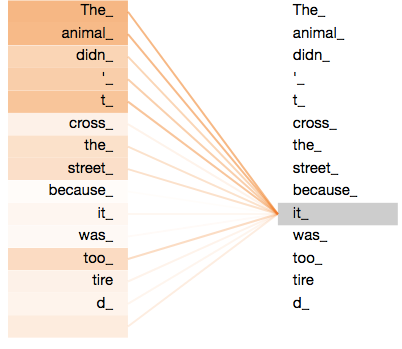

For each word, self-attention calculates an output vector **z**<sub>*i*</sub> that is the combination of all the words in the input text. Roughly speaking, this **z**<sub>*i*</sub> vector is a weighted vector measuring the significance of all words to the target word *w<sub>i</sub>*.

As every single word in the sequence is taken into account when calculating the output vector **z<sub>i</sub>**, self-attention can "look both ways", and is capable of representing long-distance dependencies.

### Transformer layers

Self-attention allows transformer-based language models to be context-sensitive in ways previous frameworks did not allow. Additionally, thanks to their parallel nature, transformers can be trained more efficiently, enabling today's staggering model sizes like the 120 transformer layers and approximately 1.8 trillion parameters in the case of GPT-4.

Transformer layers typically have an architecture similar to the one in this figure:

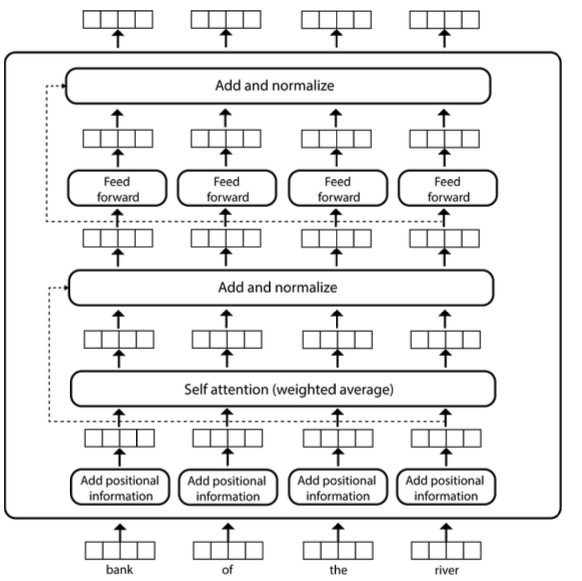

## How to (pre)train your transformers?

Transformer-based models are often used in the *pretrain and fine-tune* framework. Large unlabelled textual datasets are used for the pretraining process that allows these models to learn robust general language knowledge. This knowledge can be leveraged in the fine-tuning process where smaller, labelled datasets can be used to adapt the model to a target task.

Starting your training procedure from a pre-trained model reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch.

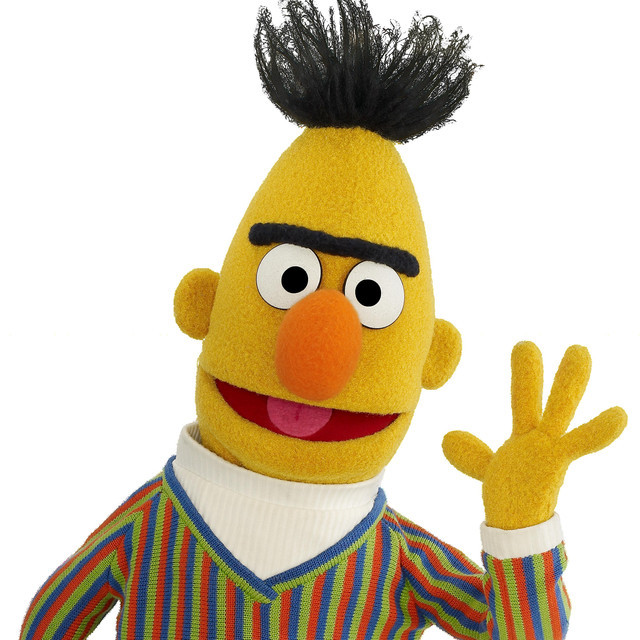

In the following examples we are going to deal with BERT and related models. BERT beat the previous state-of-the-art results in NLP and it and its related models became ubiquotous in NLP.

Compared to more recent models, BERT is much smaller, only having 12 transformer layers and 110 million parameters and when performance is priority, you'd probably want to use one of the larger models available today. Nevertheless, most of what is true for BERT will be true for models such as GPT-4 too.

BERT, like most transformer-based neural models is pretrained using the **masked language modelling** (MLM) objective, sometimes also called `fill-mask`. In this task, the model learns to predict what the most likely word is at a masked (hidden) position in the sentence. In a sentence like:

>There were several [MASK] with the proposed solution.
    
the model will learn that the word *problems* or *issues* is more likely at this position than the word *unicorns* or *days*. The model uses both the right and left context of the masked position to make its predictions. Models trained to maximize the probability of predicting the correct masked words learn to represent a good amount of linguistic knowledge as a result of this.

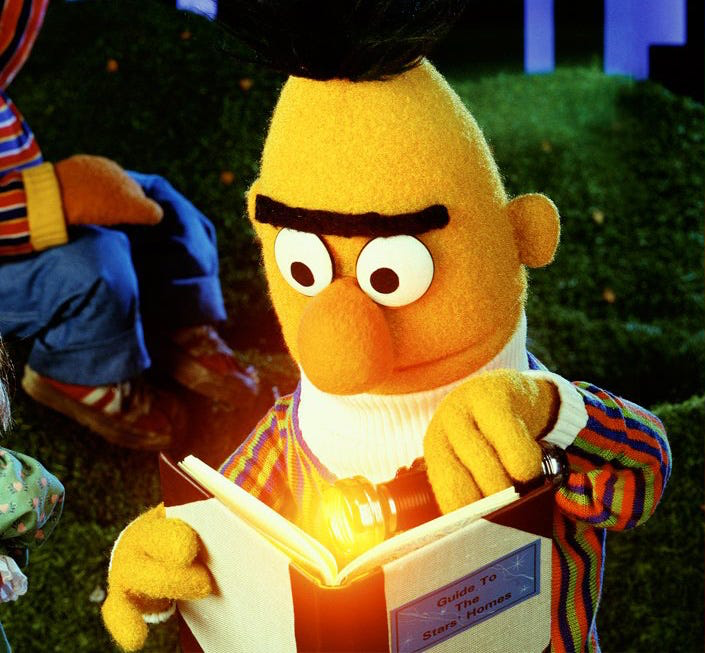

BERT also learns to recognise linguistic constraints, such as the fact that in the sentence above the masked position can be filled by a plural noun (*problems*) but not a singular one (*problem*).

While predicting whether the masked position should be filled by a singular or plural noun seems easy in the example above (both *were* and *several* are good predictors of plural), we can try to make the task harder by looking for contexts where the solution requires more careful *attention* to the right words in the context

>There were some [MASK] with the proposed solution.
>
>There could be several [MASK] with the proposed solution.
>
>There were some unexpected and unforeseen [MASK] with the proposed solution.
    
In the examples above, the task is made harder by replacing *several* (which is always followed by a plural noun) by *some* (which can be followed by a singular or a plural noun), by replacing *were* (which always heads a sentence with a plural subject) by *could be* (which can head a sentence with a singular or plural subject), and by inserting material between the verb *were* (which indicates that there should be a plural) and the MASK.

### Let's do some inference!

In NLP research, transformer-based models are generally deployed via 🤗 Transformers. For certain dedicated tasks, including MLM, we can also find pipelines that can be used to do quick inference, abstracting away most implementation details.

In the first example, we can use the MLM pipeline to gain insight into what various language models learnt during their pretraining. The first model we will be using for this task is the [multilingual BERT](https://huggingface.co/bert-base-multilingual-cased) model that was trained on the Wikipedia text of the 102 largest Wikipedia's. This means that you do not have to choose examples from English, but that you may also present sentences in another language, like Danish or any other you might be speaking.

The following loads the pipeline for doing masked prediction, and load the mBERT model (this may take a minute or so). You can ignore the warning about some weights not being initialized. The pipeline can be used to test masked language model prediction. Given a sequence containing the special token [MASK], the model will predict what the most likely tokens are at that position, using both left and right context.

In [2]:
from transformers import pipeline

mlm_pipeline = pipeline("fill-mask", model="bert-base-multilingual-cased")
mlm_pipeline("There were some unexpected and unforeseen [MASK] with the proposed solution.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.5272426605224609,
  'token': 20390,
  'token_str': 'problems',
  'sequence': 'There were some unexpected and unforeseen problems with the proposed solution.'},
 {'score': 0.09590253233909607,
  'token': 17850,
  'token_str': 'issues',
  'sequence': 'There were some unexpected and unforeseen issues with the proposed solution.'},
 {'score': 0.06644545495510101,
  'token': 64557,
  'token_str': 'difficulties',
  'sequence': 'There were some unexpected and unforeseen difficulties with the proposed solution.'},
 {'score': 0.016898171976208687,
  'token': 73082,
  'token_str': 'dealing',
  'sequence': 'There were some unexpected and unforeseen dealing with the proposed solution.'},
 {'score': 0.015166707336902618,
  'token': 18107,
  'token_str': 'associated',
  'sequence': 'There were some unexpected and unforeseen associated with the proposed solution.'}]

Using the 🤗 Transformers library, we can load and use a large number of transformer-based models from [Hugging Face Model Hub](https://huggingface.co/models).

#### Practice

Can you load and carry out inference with another language model from the Hugging Face model hub?

In [ ]:
# Load and test your model here



## Fine-tuning and inference with 🤗 Transformers

*Adapted from the [🤗 Transformers documentation](https://huggingface.co/transformers/training.html)*

In this notebook we will see how to use 🤗 Transformers to finetune a model on a downstream task and how to use it for inference.

### Preprocessing

The pipelines we have used before abstract away from a lot of the nitty-gritty of using transformer models. When we look closer, however, we have to understand that input data has to be preprocessed to an appropriate format to be usable by these models.

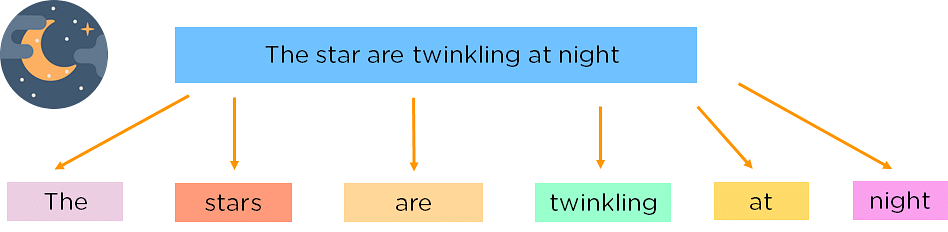

This preprocessing is made up of two distinct steps:

1. Tokenization
2. Padding/truncation

Tokenization involves splitting an input sentence into a series of tokens. Transformer models are typically relying on statistically-driven subword tokenization algorithms to build their model vocabulary. One such algorithm is Byte-Pair Encoding. Details of it are not important, but this means that in many cases resulting tokens do not always correspond to full words.

Additionally, as transformer models expect every input sequence to be uniform length (corresponding to their maximum sequence length), shorter sequences have to be padded while longer ones have to be truncated.

We also have to understand that transformer models also come with special tokens, usually to mark the start of a sequence, the end of a sequence, and any padding that may be added.

Fortunately, in practice 🤗 Transformers tokenizers can be used to take care of all these implementation details for us. In the following steps, we are using ALBERT, a transformer-based monolingual English model that is smaller and faster to train than the "classic" BERT model.

In [3]:
# load target model tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# retrieve human-readable tokenization
tokenizer.tokenize("Where is the Himalayas in the world map?",
                   add_special_tokens=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

['[CLS]',
 '▁where',
 '▁is',
 '▁the',
 '▁him',
 'alaya',
 's',
 '▁in',
 '▁the',
 '▁world',
 '▁map',
 '?',
 '[SEP]']

In [4]:
# call the tokenizer directly to get all the relevant input
tokenizer("Where is the Himalayas in the world map?", padding="max_length")

{'input_ids': [2, 113, 25, 14, 61, 14223, 18, 19, 14, 126, 2942, 60, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 🤗 Datasets

When intending to carry out fine-tuning with the transformers library, it is usually a wise idea to try to load any data using 🤗 Datasets since it offers a lot of convenience functions for preparing the data.

To illustrate how this library can be used, let's load the Yelp Reviews dataset, one of the default datasets in the 🤗 Datasets library:

In [5]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

dataset

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [6]:
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

We can use our previously defined tokenizer to write a helper function for preprocessing the dataset:

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

We can apply this to our dataset in one step, using the `map` method.

To speed up the process, let's limit the size of the dataset for now.

In [8]:
# this is only necessary to make things go faster
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(500))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(500))

In [9]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [12]:
tokenized_dataset["train"][0]

{'label': 4,
 'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!",
 'input_ids': [2,
  31,
  19364,
  48,
  2956,
  9,
  31,
  22,
  195,
  74,
  20,
  2163,
  6450,
  113,
  31,
  8019,
  20,
  44,
  21,
  6145,
  7444,
  1288,
  19,
  293,
  15,
  4998,
  3668,
  4271,
  7503,
  15,
  17,
  16,
  674,
  14,
  7016,
  22,
  18,
  1135,
  9,
  14,
  2557,
  18,
  50,
  86,
  86,
  6916,
  7069,
  9,
  14,
  2410,
  25,
  1026,
  4753,
  17,
  24,
  1364,
  206,
  2557,
  34,
  224,
  29,
  40,
  10287,
  2006,
  16,
  5364,
  9,
  42,
  12185,
  2749,
  235,
  2776,
  28116,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

## Train

🤗 Transformers provides a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) class optimized for training 🤗 Transformers models, making it easier to start training without manually writing your own training loop. The Trainer API supports a wide range of training options and features such as logging, gradient accumulation, and mixed precision. Start by loading your model and specify the number of expected labels. From the Yelp Review dataset card, you know there are five labels.

>You will see a warning about some of the pretrained weights not being used and some weights being randomly initialized. Don’t worry, this is completely normal! The pretrained head of ALBERT is discarded, and replaced with a randomly initialized classification head. You will fine-tune this new model head on your sequence classification task, transferring the knowledge of the pretrained model to it.

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2",
                                                           num_labels=5)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, create a [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training hyperparameters, but feel free to experiment with these to find your optimal settings.

Specify where to save the checkpoints (i.e., training stages) from your training:

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

## Evaluate

Trainer does not automatically evaluate model performance during training. You’ll need to pass Trainer a function to compute and report metrics. The 🤗 Evaluate library provides a simple accuracy function you can load with the`evaluate.load` (see this [quicktour](https://huggingface.co/docs/evaluate/a_quick_tour) for more information) function:

In [15]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

Call `compute` on the metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the predictions to logits (remember all 🤗 Transformers models return logits):

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

If you’d like to monitor your evaluation metrics during fine-tuning, specify the `evaluation_strategy` parameter in your training arguments to report the evaluation metric at the end of each epoch. The [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) class is highly customizable with all common training parameters (e.g. epoch count, learning rate, batch size, etc.) and flags for activating different training options (e.g. mixed precision, gradient accumulation). See the link for more information.

In [17]:
# find example dataset

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) object with your model, training arguments, training and test datasets, and evaluation function:

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    report_to=None
)

Then fine-tune your model by calling `train()`:

In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

Now we can load the model and tokenizer from the checkpoint directory and use it to predict the sentiment of a new review:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("test_trainer/checkpoint-1500",
                                                           num_labels=5)
# We didn't save tokenizer in the folder, so we need to reload it
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [ ]:
import torch

text = "Don't waste your time. We had two different people come to our house to give us estimates for a deck (one of them the OWNER). Both times, we never heard from them. Not a call, not the estimate, nothing."

tokens = tokenizer(text, padding=True, return_tensors="pt")
output = model(**tokens)
probs = torch.nn.functional.softmax(output.logits, dim=-1).tolist()
print(probs)

## Training with your own data

Now you know how you can finetune a transformer model on a predefined dataset using the 🤗 Datasets library. However, in most cases, you want to be able to load your own data.

To practice, let's use the [Spam Emails Dataset](https://www.kaggle.com/datasets/abdallahwagih/spam-emails) of Abdallah Wagih Ibrahim from kaggle. I copied the `csv` file to my own github so that we can easily download it from there.

In [ ]:
!wget -O spam_emails.csv https://raw.githubusercontent.com/vrmer/language-modeling-with-transformers/main/data/spam.csv

Let's examine the dataset first before processing it.

In [ ]:
import pandas as pd

df = pd.read_csv("spam_emails.csv")

In [ ]:
df.groupby("Category").count()

There's multiple problems with the format as it is. First, 🤗 Transformers expects the column containing labels to be called `label` and the column containing the text to be called `text`. Additionally, labels should be numerical. In binary classification, it is convenient to use 0 and 1, for example. It is also not ideal that there is such a label imbalance.

Let's carry out some preprocessing to get the right format!

In [ ]:
# first, let's make sure the label distribution is roughly equal


In [ ]:
# preprocess the dataset to get the right format
# your code goes here:

If we are confident the data is in the right format, we can use 🤗 Datasets to load it.

In [ ]:
from datasets import Dataset

spam_dataset = Dataset.from_pandas(df)

spam_dataset

To create a training and test split from our newly loaded dataset, we can use the `train_test_split` method with the test size specified as a fraction of the dataset, in this case, 10%.

In [ ]:
spam_dataset = spam_dataset.train_test_split(test_size=0.1)

spam_dataset

### Exercise

Carry out the rest of the fine-tuning process using the `spam_dataset`. Remember when you are loading your model, you want to initialise it with the right value for the parameter `num_labels`. Also, don't forget to define new training arguments to prevent overwriting your previously trained model and to be able to change hyperparameters.

In [ ]:
# this is where your code is going


### Test your model

In [ ]:
text = ""

tokens = tokenizer(text, padding=True, return_tensors="pt").to("cuda")
output = model(**tokens)
probs = torch.nn.functional.softmax(output.logits, dim=-1).tolist()
print(probs)